# Coursework 3

## CIFAR 100

#### imports + data

In [1]:
import os
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
%matplotlib inline

# import data providers
train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)
mini_train_data = CIFAR100DataProvider('train', batch_size=50, input_num=10000)
mini_valid_data = CIFAR100DataProvider('valid', batch_size=50, input_num=2000)

In [2]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu, weights=None):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

This set of experiments explore the improvement in performance when changing the learning rule of the NN to classify objects in the CIFAR 100 dataset

In [3]:
# ----- NETWORK DEFINITION ------------

tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
num_hidden1 = 400
num_hidden2 = 200

# --- define NN ---
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden1)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden1, num_hidden2)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_2, num_hidden2, train_data.num_classes, tf.identity)
# --- define error computation ---
with tf.name_scope('error'):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))

# Performance with different Learning rules

### Simple Gradiant Descent

#### hyperparameter search: eta

---- Eta=0.001 ----
                 err(valid)=4.51 acc(valid)=0.03
                 err(valid)=4.42 acc(valid)=0.05
                 err(valid)=4.33 acc(valid)=0.06
                 err(valid)=4.25 acc(valid)=0.06
                 err(valid)=4.18 acc(valid)=0.07
                 err(valid)=4.12 acc(valid)=0.08
                 err(valid)=4.07 acc(valid)=0.08
                 err(valid)=4.02 acc(valid)=0.10
                 err(valid)=3.99 acc(valid)=0.10
                 err(valid)=3.96 acc(valid)=0.11
                 err(valid)=3.94 acc(valid)=0.11
                 err(valid)=3.91 acc(valid)=0.12
                 err(valid)=3.90 acc(valid)=0.12
                 err(valid)=3.88 acc(valid)=0.12
                 err(valid)=3.86 acc(valid)=0.12
                 err(valid)=3.84 acc(valid)=0.12
                 err(valid)=3.84 acc(valid)=0.12
                 err(valid)=3.82 acc(valid)=0.13
                 err(valid)=3.81 acc(valid)=0.14
                 err(valid)=3.80 acc(valid)=0.14


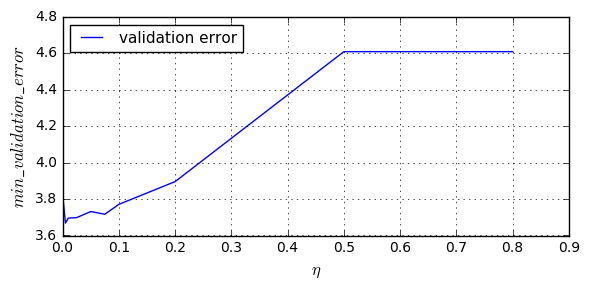

In [4]:
learning_rates = [0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.5, 0.8]

val_mins = []

for learning_rate in learning_rates:

    print("---- Eta="+str(learning_rate)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(learning_rate, min(validation_errors))]

_, eta_search_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(learning_rates, 
              eta_search_errors, label='validation error')
ax.set_xlabel('$\eta$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('gd_eta_search.pdf') 

print("------  eta search  --------")
print("minimum validation error is {} for eta={}".format(val_mins[0][1], val_mins[0][0]))
eta_simple_grad_descent = val_mins[0][0]

### Momentum Learning Rule

#### Eta search

---- Eta=1e-05 ----
                 err(valid)=4.67 acc(valid)=0.01
                 err(valid)=4.63 acc(valid)=0.02
                 err(valid)=4.61 acc(valid)=0.02
                 err(valid)=4.59 acc(valid)=0.02
                 err(valid)=4.58 acc(valid)=0.02
                 err(valid)=4.57 acc(valid)=0.02
                 err(valid)=4.55 acc(valid)=0.02
                 err(valid)=4.54 acc(valid)=0.02
                 err(valid)=4.54 acc(valid)=0.03
                 err(valid)=4.53 acc(valid)=0.03
                 err(valid)=4.52 acc(valid)=0.03
                 err(valid)=4.51 acc(valid)=0.03
                 err(valid)=4.50 acc(valid)=0.04
                 err(valid)=4.49 acc(valid)=0.04
                 err(valid)=4.49 acc(valid)=0.04
                 err(valid)=4.48 acc(valid)=0.04
                 err(valid)=4.47 acc(valid)=0.04
                 err(valid)=4.46 acc(valid)=0.04
                 err(valid)=4.45 acc(valid)=0.04
                 err(valid)=4.45 acc(valid)=0.04


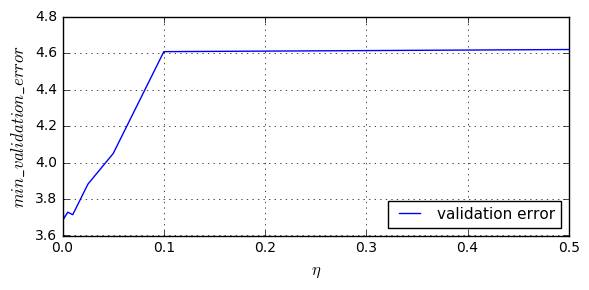

In [5]:
learning_rates = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]

val_mins = []

for learning_rate in learning_rates:

    print("---- Eta="+str(learning_rate)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(learning_rate, min(validation_errors))]

_, eta_momentum_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(learning_rates, eta_momentum_errors, label='validation error')
ax.set_xlabel('$\eta$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('momentum_eta_search.pdf') 

print("------  eta search  --------")
print("minimum validation error is {} for eta={}".format(val_mins[0][1], val_mins[0][0]))
eta_momentum_rule = val_mins[0][0]

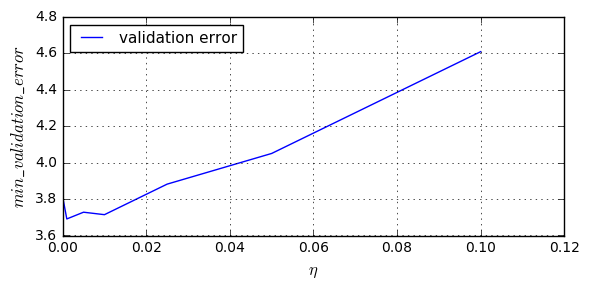

In [14]:
learning_rates = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(learning_rates[:len(learning_rates)-2], eta_momentum_errors[:len(eta_momentum_errors)-2], label='validation error')
ax.set_xlabel('$\eta$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('momentum_eta_searchMAYBE.pdf')

#### Alpha search

---- Alpha=0.6 ----
                 err(valid)=4.42 acc(valid)=0.05
                 err(valid)=4.24 acc(valid)=0.06
                 err(valid)=4.09 acc(valid)=0.09
                 err(valid)=4.01 acc(valid)=0.10
                 err(valid)=3.95 acc(valid)=0.11
                 err(valid)=3.90 acc(valid)=0.11
                 err(valid)=3.84 acc(valid)=0.13
                 err(valid)=3.81 acc(valid)=0.14
                 err(valid)=3.78 acc(valid)=0.14
                 err(valid)=3.77 acc(valid)=0.15
                 err(valid)=3.75 acc(valid)=0.14
                 err(valid)=3.73 acc(valid)=0.15
                 err(valid)=3.71 acc(valid)=0.16
                 err(valid)=3.71 acc(valid)=0.16
                 err(valid)=3.70 acc(valid)=0.16
                 err(valid)=3.70 acc(valid)=0.15
                 err(valid)=3.68 acc(valid)=0.17
                 err(valid)=3.69 acc(valid)=0.16
                 err(valid)=3.67 acc(valid)=0.17
                 err(valid)=3.66 acc(valid)=0.18


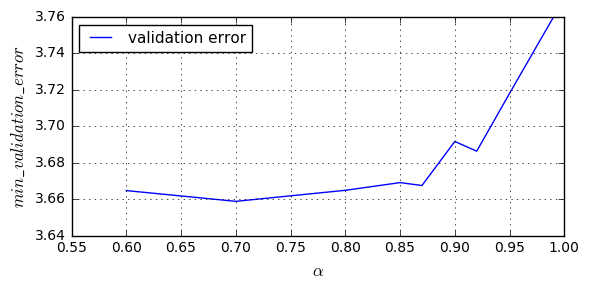

In [6]:
momentums = [0.6, 0.7, 0.8, 0.85, 0.87, 0.9, 0.92, 0.95, 0.99]

val_mins = []

for momentum in momentums:

    print("---- Alpha="+str(momentum)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.MomentumOptimizer(learning_rate=eta_momentum_rule, momentum=momentum).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(momentum, min(validation_errors))]

_, alpha_momentum_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER Alpha
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)

ax.plot(momentums, alpha_momentum_errors, label='validation error')

ax.set_xlabel('$\\alpha$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('Momentum_alpha_search.pdf') 

print("------  Alpha search  --------")
print("minimum validation error is {} for Alpha={}".format(val_mins[0][1], val_mins[0][0]))
alpha_momentum_rule = val_mins[0][0]

### RMSProp


#### eta search

---- Eta=1e-05 ----
                 err(valid)=4.43 acc(valid)=0.04
                 err(valid)=4.30 acc(valid)=0.06
                 err(valid)=4.20 acc(valid)=0.08
                 err(valid)=4.12 acc(valid)=0.09
                 err(valid)=4.06 acc(valid)=0.10
                 err(valid)=4.01 acc(valid)=0.12
                 err(valid)=3.98 acc(valid)=0.11
                 err(valid)=3.95 acc(valid)=0.12
                 err(valid)=3.91 acc(valid)=0.12
                 err(valid)=3.90 acc(valid)=0.13
                 err(valid)=3.87 acc(valid)=0.12
                 err(valid)=3.86 acc(valid)=0.13
                 err(valid)=3.84 acc(valid)=0.13
                 err(valid)=3.83 acc(valid)=0.14
                 err(valid)=3.82 acc(valid)=0.14
                 err(valid)=3.81 acc(valid)=0.14
                 err(valid)=3.79 acc(valid)=0.15
                 err(valid)=3.78 acc(valid)=0.14
                 err(valid)=3.76 acc(valid)=0.15
                 err(valid)=3.77 acc(valid)=0.15


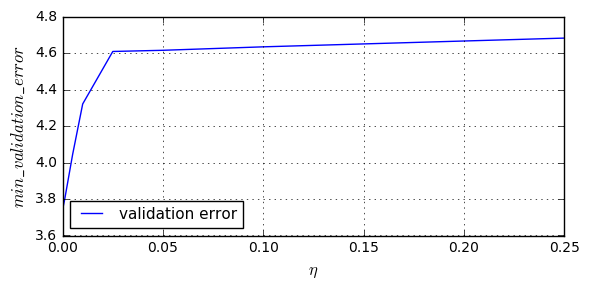

In [7]:
learning_rates = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25]

val_mins = []

for learning_rate in learning_rates:

    print("---- Eta="+str(learning_rate)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=0.9).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(learning_rate, min(validation_errors))]

_, eta_rmsprop_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)

ax.plot(learning_rates, eta_rmsprop_errors, label='validation error')

ax.set_xlabel('$\eta$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('rmsprop_eta_search.pdf') 

print("------  eta search  --------")
print("minimum validation error is {} for eta={}".format(val_mins[0][1], val_mins[0][0]))
eta_RMSProp_rule = 0.0001

#### beta search

---- Beta=0.60001 ----
                 err(valid)=4.05 acc(valid)=0.09
                 err(valid)=3.90 acc(valid)=0.11
                 err(valid)=3.81 acc(valid)=0.14
                 err(valid)=3.75 acc(valid)=0.16
                 err(valid)=3.81 acc(valid)=0.15
                 err(valid)=3.89 acc(valid)=0.14
                 err(valid)=3.85 acc(valid)=0.15
                 err(valid)=3.85 acc(valid)=0.15
                 err(valid)=3.79 acc(valid)=0.17
                 err(valid)=3.89 acc(valid)=0.15
                 err(valid)=3.99 acc(valid)=0.15
                 err(valid)=3.92 acc(valid)=0.17
                 err(valid)=4.01 acc(valid)=0.16
                 err(valid)=4.04 acc(valid)=0.16
                 err(valid)=4.11 acc(valid)=0.16
                 err(valid)=4.19 acc(valid)=0.17
                 err(valid)=4.31 acc(valid)=0.16
                 err(valid)=4.30 acc(valid)=0.16
                 err(valid)=4.43 acc(valid)=0.15
                 err(valid)=4.44 acc(valid)=0.

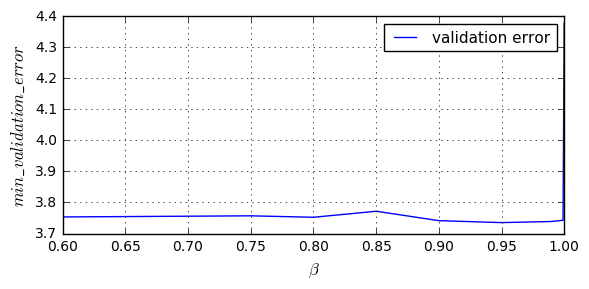

In [4]:
decays = [0.60001, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.999, 0.9999]

val_mins = []

for decay in decays:

    print("---- Beta="+str(decay)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.RMSPropOptimizer(learning_rate=0.0001, decay=decay).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(decay, min(validation_errors))]

_, beta_rmsprop_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)

ax.plot(decays, beta_rmsprop_errors, label='validation error')

ax.set_xlabel('$\\beta$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('rmsprop_beta_search.pdf') 

print("------  beta search  --------")
print("minimum validation error is {} for beta={}".format(val_mins[0][1], val_mins[0][0]))
beta_RMSProp_rule = val_mins[0][0]

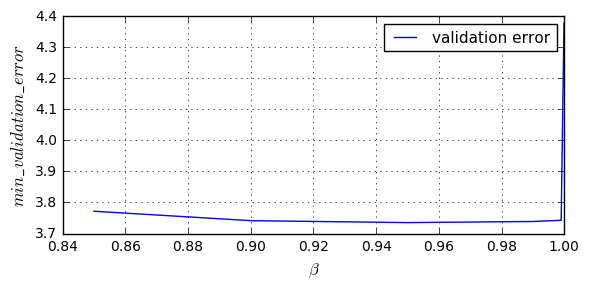

### ADAM

#### eta search

---- Eta=1e-05 ----
                 err(valid)=4.41 acc(valid)=0.04
                 err(valid)=4.26 acc(valid)=0.06
                 err(valid)=4.14 acc(valid)=0.09
                 err(valid)=4.06 acc(valid)=0.10
                 err(valid)=4.00 acc(valid)=0.11
                 err(valid)=3.96 acc(valid)=0.11
                 err(valid)=3.93 acc(valid)=0.13
                 err(valid)=3.89 acc(valid)=0.12
                 err(valid)=3.88 acc(valid)=0.13
                 err(valid)=3.85 acc(valid)=0.13
                 err(valid)=3.83 acc(valid)=0.14
                 err(valid)=3.81 acc(valid)=0.15
                 err(valid)=3.81 acc(valid)=0.14
                 err(valid)=3.78 acc(valid)=0.15
                 err(valid)=3.78 acc(valid)=0.15
                 err(valid)=3.76 acc(valid)=0.16
                 err(valid)=3.75 acc(valid)=0.15
                 err(valid)=3.75 acc(valid)=0.16
                 err(valid)=3.73 acc(valid)=0.16
                 err(valid)=3.73 acc(valid)=0.16


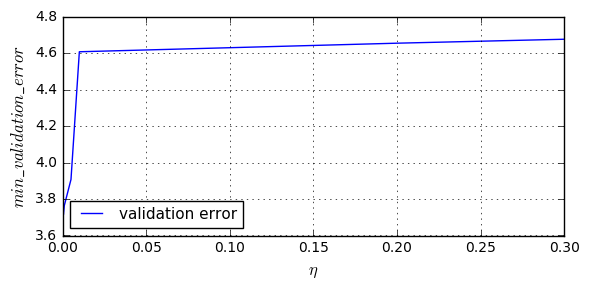

In [8]:
learning_rates = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.2, 0.3]

val_mins = []

for learning_rate in learning_rates:

    print("---- Eta="+str(learning_rate)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(learning_rate, min(validation_errors))]

_, eta_adam_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(learning_rates, eta_adam_errors, label='validation error')
ax.set_xlabel('$\eta$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('adam_eta_search.pdf') 

print("------  eta search  --------")
print("minimum validation error is {} for eta={}".format(val_mins[0][1], val_mins[0][0]))
eta_adam_rule = val_mins[0][0]

#### beta1 search

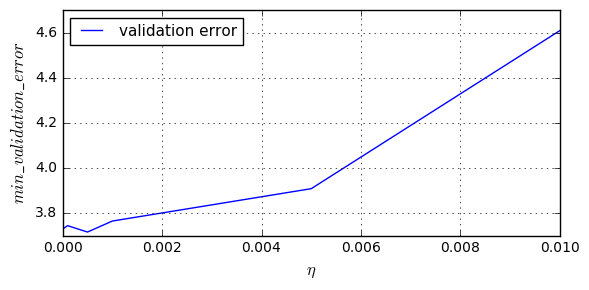

---- Beta1=0.85 ----
                 err(valid)=3.84 acc(valid)=0.12
                 err(valid)=3.71 acc(valid)=0.15
                 err(valid)=3.78 acc(valid)=0.15
                 err(valid)=3.84 acc(valid)=0.17
                 err(valid)=3.91 acc(valid)=0.18
                 err(valid)=4.09 acc(valid)=0.17
                 err(valid)=4.31 acc(valid)=0.16
                 err(valid)=4.50 acc(valid)=0.17
                 err(valid)=4.84 acc(valid)=0.16
                 err(valid)=5.10 acc(valid)=0.16
                 err(valid)=5.51 acc(valid)=0.16
                 err(valid)=5.85 acc(valid)=0.15
                 err(valid)=6.10 acc(valid)=0.16
                 err(valid)=6.47 acc(valid)=0.15
                 err(valid)=6.93 acc(valid)=0.16
                 err(valid)=7.31 acc(valid)=0.15
                 err(valid)=7.76 acc(valid)=0.15
                 err(valid)=8.15 acc(valid)=0.16
                 err(valid)=8.56 acc(valid)=0.15
                 err(valid)=9.03 acc(valid)=0.15

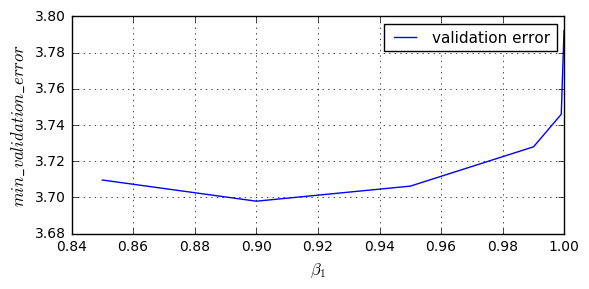

In [19]:
beta1s = [0.85, 0.9, 0.95, 0.99, 0.999, 0.9999]

val_mins = []

for beta in beta1s:

    print("---- Beta1="+str(beta)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=eta_adam_rule, beta1=beta, beta2=0.999).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(beta, min(validation_errors))]

_, beta1_adam_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)

ax.plot(beta1s, beta1_adam_errors, label='validation error')

ax.set_xlabel('$\\beta_1$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('adam_beta1_search.pdf') 

print("------  beta1 search  --------")
print("minimum validation error is {} for beta2={}".format(val_mins[0][1], val_mins[0][0]))
beta1_adam_rule = val_mins[0][0]

In [22]:
print(eta_adam_rule)
print(beta1_adam_rule)

0.0005
0.9


#### beta2 search

---- Beta2=0.85 ----
                 err(valid)=3.98 acc(valid)=0.08
                 err(valid)=3.74 acc(valid)=0.14
                 err(valid)=3.71 acc(valid)=0.15
                 err(valid)=3.73 acc(valid)=0.16
                 err(valid)=3.80 acc(valid)=0.17
                 err(valid)=3.86 acc(valid)=0.17
                 err(valid)=3.94 acc(valid)=0.17
                 err(valid)=4.05 acc(valid)=0.17
                 err(valid)=4.29 acc(valid)=0.16
                 err(valid)=4.42 acc(valid)=0.17
                 err(valid)=4.68 acc(valid)=0.15
                 err(valid)=4.72 acc(valid)=0.16
                 err(valid)=5.14 acc(valid)=0.15
                 err(valid)=5.18 acc(valid)=0.16
                 err(valid)=5.33 acc(valid)=0.15
                 err(valid)=5.66 acc(valid)=0.14
                 err(valid)=6.06 acc(valid)=0.16
                 err(valid)=6.18 acc(valid)=0.15
                 err(valid)=6.47 acc(valid)=0.16
                 err(valid)=7.00 acc(valid)=0.15

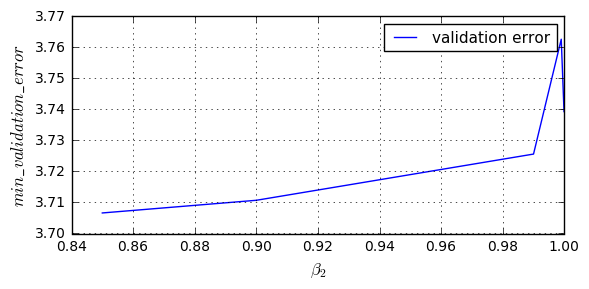

In [20]:
beta2s = [0.85, 0.9, 0.99, 0.999, 0.9999]

val_mins = []

for beta in beta2s:

    print("---- Beta2="+str(beta)+" ----")
    # --- define training rule ---
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=eta_adam_rule, beta1=beta1_adam_rule, beta2=beta).minimize(error)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    validation_errors = []
    for e in range(100):
        # training step
        for input_batch, target_batch in mini_train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            
        if ((e+1)%5==0):
            # validate
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in mini_valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= mini_valid_data.num_batches
            valid_accuracy /= mini_valid_data.num_batches
            validation_errors += [valid_error]
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
    val_mins += [(beta, min(validation_errors))]

_, beta2_adam_errors = zip(*val_mins)
val_mins.sort(key=lambda x:x[1])

# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(beta2s, beta2_adam_errors, label='validation error')
ax.set_xlabel('$\\beta_2$', fontsize=12)
ax.set_ylabel('$min\_validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('adam_beta2_search.pdf') 

print("------  beta2 search  --------")
print("minimum validation error is {} for beta2={}".format(val_mins[0][1], val_mins[0][0]))
beta2_adam_rule = val_mins[0][0]

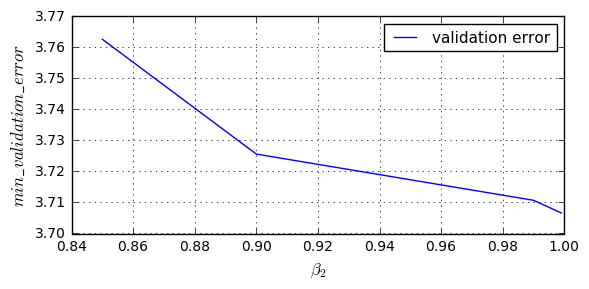

### Learning Rules Comparison

---------- Gradient Descent-----------
                 err(valid)=3.803407 acc(valid)=0.132300
                 err(valid)=3.621158 acc(valid)=0.164600
                 err(valid)=3.555720 acc(valid)=0.177800
                 err(valid)=3.463337 acc(valid)=0.192900
                 err(valid)=3.431624 acc(valid)=0.198200
                 err(valid)=3.397606 acc(valid)=0.198200
                 err(valid)=3.347736 acc(valid)=0.211400
                 err(valid)=3.299195 acc(valid)=0.224800
                 err(valid)=3.297859 acc(valid)=0.222500
                 err(valid)=3.268627 acc(valid)=0.230200
                 err(valid)=3.253604 acc(valid)=0.231600
                 err(valid)=3.267688 acc(valid)=0.227100
                 err(valid)=3.242161 acc(valid)=0.238400
                 err(valid)=3.237207 acc(valid)=0.237000
                 err(valid)=3.244648 acc(valid)=0.241300
                 err(valid)=3.259941 acc(valid)=0.238900
                 err(valid)=3.272201 acc(valid)=0

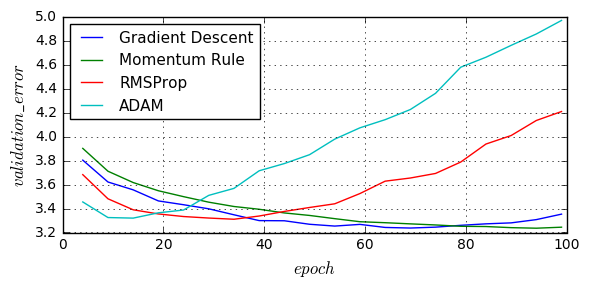

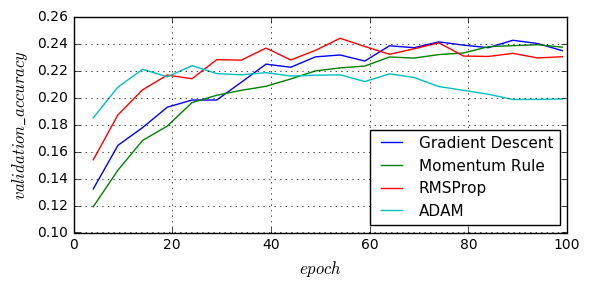

In [25]:
import time

eta_simple_grad_descent = 0.005
eta_momentum_rule = 0.001
alpha_momentum_rule = 0.7
eta_RMSProp_rule = 0.0001
beta_RMSProp_rule = 0.95
eta_adam_rule = 0.0005
beta1_adam_rule = 0.9
beta2_adam_rule = 0.9999

# --------------- GRADIENT DESCENT ----------------
print('---------- Gradient Descent-----------')
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate=eta_simple_grad_descent).minimize(error)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
epochs = []
grad_descent_valid_error = []
grad_descent_valid_acc = []

t = time.time()
for e in range(100):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        
        epochs += [e]
        grad_descent_valid_error += [valid_error]
        grad_descent_valid_acc += [valid_accuracy]
        
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))
grad_descent_time = time.time() - t
# --------------- MOMENTUM rule ----------------
print('---------- Momentum Rule-----------')
with tf.name_scope('train'):
    train_step = tf.train.MomentumOptimizer(learning_rate=eta_momentum_rule, momentum=alpha_momentum_rule).minimize(error)
    
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
momentum_valid_error = []
momentum_valid_acc = []

t = time.time()
for e in range(100):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        momentum_valid_error += [valid_error]
        momentum_valid_acc += [valid_accuracy]
        
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))
momentum_time = time.time() - t

# --------------- RMSProp rule ----------------
print('---------- RMSPror Rule-----------')
with tf.name_scope('train'):
    train_step = tf.train.RMSPropOptimizer(learning_rate=eta_RMSProp_rule, decay=beta_RMSProp_rule).minimize(error)
    
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
rmsprop_valid_error = []
rmsprop_valid_acc = []

t = time.time()
for e in range(100):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        rmsprop_valid_error += [valid_error]
        rmsprop_valid_acc += [valid_accuracy]
        
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))
rmsprop_time = time.time() - t

# --------------- Adam rule ----------------
print('---------- Adam Rule-----------')
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=eta_adam_rule, beta1=beta1_adam_rule, beta2=beta2_adam_rule).minimize(error)
    
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
adam_valid_error = []
adam_valid_acc = []

t = time.time()
for e in range(100):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        adam_valid_error += [valid_error]
        adam_valid_acc += [valid_accuracy]
        
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))
adam_time = time.time() - t



#---------- errors -------
fig_size = (6, 3) 
fig1 = plt.figure(figsize=fig_size)
ax = fig1.add_subplot(1, 1, 1)

ax.plot(epochs, grad_descent_valid_error, label='Gradient Descent')
ax.plot(epochs, momentum_valid_error, label='Momentum Rule')
ax.plot(epochs, rmsprop_valid_error, label='RMSProp')
ax.plot(epochs, adam_valid_error, label='ADAM')

ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig1.tight_layout() 
fig1.savefig('opt_rules_error_comparison.pdf') 

#---------- accuracies -------
 
fig2 = plt.figure(figsize=fig_size)
ax = fig2.add_subplot(1, 1, 1)

ax.plot(epochs, grad_descent_valid_acc, label='Gradient Descent')
ax.plot(epochs, momentum_valid_acc, label='Momentum Rule')
ax.plot(epochs, rmsprop_valid_acc, label='RMSProp')
ax.plot(epochs, adam_valid_acc, label='ADAM')

ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_accuracy$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig2.tight_layout() 
fig2.savefig('opt_rules_acc_comparison.pdf') 

print("-----GRADIENT DESCENT-------")
print("min validation error: "+str(min(grad_descent_valid_error)))
print("max accuracy: "+str(max(grad_descent_valid_acc)))
print("training time: "+str(grad_descent_time))
print("-----MOMENTUM RULE-------")
print("min validation error: "+str(min(momentum_valid_error)))
print("max accuracy: "+str(max(momentum_valid_acc)))
print("training time: "+str(momentum_time))
print("-----RMSPROP RULE-------")
print("min validation error: "+str(min(rmsprop_valid_error)))
print("max accuracy: "+str(max(rmsprop_valid_acc)))
print("training time: "+str(rmsprop_time))
print("-----ADAM RULE-------")
print("min validation error: "+str(min(adam_valid_error)))
print("max accuracy: "+str(max(adam_valid_acc)))
print("training time: "+str(adam_time))

#  Autoencoders vs Drop-out

## Autoencoder

#### Auto-encoder network for hidden layer 1

In [81]:
# ----- AUTOENCODER NETWORK FOR HIDDEN LAYER 1 ------------

tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')

input_dim = train_data.inputs.shape[1]
output_dim = train_data.num_classes
hid1_dim = 400
hid2_dim = 200

# --- define NN for pretraining layer 1 ---
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, input_dim, hid1_dim)
with tf.name_scope('output-pretrain_layer1'):
    outputs_pt_layer_1 = fully_connected_layer(hidden_1, hid1_dim, input_dim, tf.identity)
# --- define error computation ---
with tf.name_scope('error_pretrain_layer1'):
    error_pt_layer_1 = tf.reduce_mean(tf.pow(outputs_pt_layer_1-inputs, 2))
# --- define training rule ---
with tf.name_scope('pretrain_layer1'):
    train_step_layer_1 = tf.train.GradientDescentOptimizer(learning_rate=0.25).minimize(error_pt_layer_1)
    
    
# --- define NN for pretraining layer 2 ---
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, hid1_dim, hid2_dim)
with tf.name_scope('output-pretrain_layer2'):
    outputs_pt_layer_2 = fully_connected_layer(hidden_2, hid2_dim, input_dim, tf.identity)
# --- define error computation ---
with tf.name_scope('error_pretrain_layer2'):
    error_pt_layer_2 = tf.reduce_mean(tf.pow(outputs_pt_layer_2-inputs, 2))
# --- define training rule ---
with tf.name_scope('pretrain_layer1'):
    train_step_layer_2 = tf.train.GradientDescentOptimizer(learning_rate=0.25).minimize(error_pt_layer_2)
    
# --- define NN ---
with tf.name_scope('output'):
    outputs = fully_connected_layer(hidden_2, hid2_dim, output_dim, tf.identity)
# --- define training rule ---
with tf.name_scope('error'):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate=0.005).minimize(error)
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))

In [82]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
layer_1_trainerros = []
layer_1_valerrors = []
# PRETRAIN LAYER 1
for e in range(100):
    # training step
    train_error = 0.
    for input_batch, _ in train_data:
        _, batch_error = sess.run(
            [train_step_layer_1, error_pt_layer_1], 
            feed_dict={inputs: input_batch})
#         print(batch_error)
        train_error += batch_error
    train_error /= train_data.num_batches
    layer_1_trainerros += [train_error]
    print('                 err(train)={0:.4f}'.format(train_error))
    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        for input_batch, _ in valid_data:
            batch_error = sess.run(
                error_pt_layer_1, 
                feed_dict={inputs: input_batch})
            valid_error += batch_error
        valid_error /= valid_data.num_batches
        layer_1_valerrors += [valid_error]
        print('                 err(valid)={0:.4f}'.format(valid_error))
    # early stopping
    if len(layer_1_valerrors)>1 and layer_1_valerrors[-2]<layer_1_valerrors[-1]:
        break

                 err(train)=0.0360
                 err(train)=0.0484
                 err(train)=0.0432
                 err(train)=0.0372
                 err(train)=0.0331
                 err(valid)=0.0318
                 err(train)=0.0307
                 err(train)=0.0291
                 err(train)=0.0278
                 err(train)=0.0267
                 err(train)=0.0257
                 err(valid)=0.0253
                 err(train)=0.0249
                 err(train)=0.0241
                 err(train)=0.0234
                 err(train)=0.0228
                 err(train)=0.0223
                 err(valid)=0.0221
                 err(train)=0.0217
                 err(train)=0.0213
                 err(train)=0.0208
                 err(train)=0.0204
                 err(train)=0.0201
                 err(valid)=0.0200
                 err(train)=0.0197
                 err(train)=0.0194
                 err(train)=0.0191
                 err(train)=0.0188
                 err

------  layer1 search  --------
minimum validation error is 0.011212116214446724


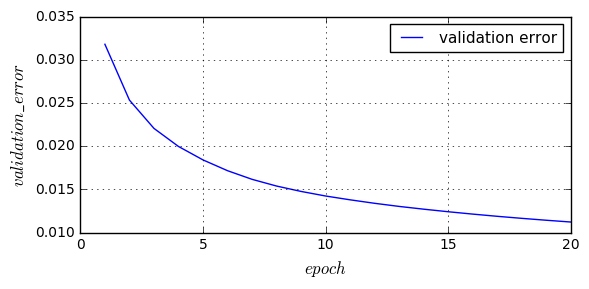

In [83]:
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, len(layer_1_valerrors)+1), layer_1_valerrors, label='validation error')
ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('autoencoder_layer1.pdf') 

print("------  layer1 search  --------")
print("minimum validation error is {}".format(min(layer_1_valerrors)))

#### Auto-encoder network for hidden layer 2

In [84]:
# PRETRAIN LAYER 2

layer_2_trainerros = []
layer_2_valerrors = []
for e in range(70):
    # training step
    train_error = 0.
    for input_batch, _ in train_data:
        _, batch_error = sess.run(
            [train_step_layer_2, error_pt_layer_2], 
            feed_dict={inputs: input_batch})
#         print(batch_error)
        train_error += batch_error
    train_error /= train_data.num_batches
    layer_2_trainerros += [train_error]
    print('                 err(train)={0:.4f}'.format(train_error))
    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        for input_batch, _ in valid_data:
            batch_error = sess.run(
                error_pt_layer_2, 
                feed_dict={inputs: input_batch})
            valid_error += batch_error
        valid_error /= valid_data.num_batches
        layer_2_valerrors += [valid_error]
        print('                 err(valid)={0:.4f}'.format(valid_error))
    # early stopping
    if len(layer_2_valerrors)>1 and layer_2_valerrors[-2]<layer_2_valerrors[-1]:
        break

                 err(train)=0.0635
                 err(train)=0.0460
                 err(train)=0.0413
                 err(train)=0.0363
                 err(train)=0.0330
                 err(valid)=0.0319
                 err(train)=0.0310
                 err(train)=0.0297
                 err(train)=0.0286
                 err(train)=0.0276
                 err(train)=0.0267
                 err(valid)=0.0263
                 err(train)=0.0258
                 err(train)=0.0251
                 err(train)=0.0244
                 err(train)=0.0238
                 err(train)=0.0233
                 err(valid)=0.0231
                 err(train)=0.0228
                 err(train)=0.0224
                 err(train)=0.0220
                 err(train)=0.0216
                 err(train)=0.0212
                 err(valid)=0.0212
                 err(train)=0.0209
                 err(train)=0.0206
                 err(train)=0.0204
                 err(train)=0.0201
                 err

------  layer2 search  --------
minimum validation error is 0.014393281168304383


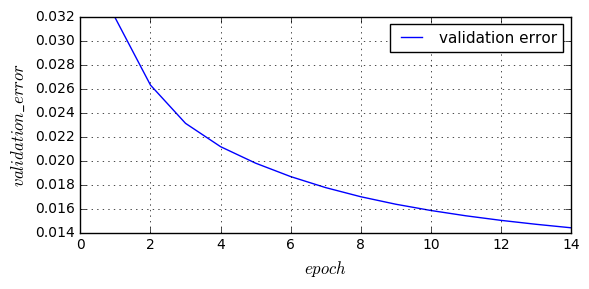

In [85]:
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, len(layer_2_valerrors)+1), layer_2_valerrors, label='validation error')
ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('autoencoder_layer2.pdf') 

print("------  layer2 search  --------")
print("minimum validation error is {}".format(min(layer_2_valerrors)))

#### Autoencoder final training

In [86]:
trainerros = []
trainaccs = []
valerrors = []
valaccs = []
validation_errors = []
# TRAIN NETWORK
for e in range(100):
    # training step
    train_error = 0.
    train_accuracy = 0.
    for input_batch, target_batch in train_data:
        _, batch_error, batch_accuracy = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})
        train_error += batch_error
        train_accuracy += batch_accuracy
    train_error /= train_data.num_batches
    train_accuracy /= train_data.num_batches
    trainerros += [train_error]
    trainaccs += [train_accuracy]
    print('                 err(train)={0:.4f} acc(train)={1:.4f}'.format(train_error, train_accuracy))
    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_accuracy = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_accuracy
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        valerrors += [valid_error]
        valaccs += [valid_accuracy]
        print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'.format(valid_error, valid_accuracy))

                 err(train)=4.6295 acc(train)=0.0114
                 err(train)=4.5112 acc(train)=0.0246
                 err(train)=4.3789 acc(train)=0.0462
                 err(train)=4.2140 acc(train)=0.0635
                 err(train)=4.0952 acc(train)=0.0789
                 err(valid)=4.0496 acc(valid)=0.0852
                 err(train)=4.0197 acc(train)=0.0917
                 err(train)=3.9611 acc(train)=0.1021
                 err(train)=3.9119 acc(train)=0.1078
                 err(train)=3.8681 acc(train)=0.1170
                 err(train)=3.8310 acc(train)=0.1215
                 err(valid)=3.8156 acc(valid)=0.1245
                 err(train)=3.7973 acc(train)=0.1273
                 err(train)=3.7688 acc(train)=0.1330
                 err(train)=3.7424 acc(train)=0.1379
                 err(train)=3.7191 acc(train)=0.1421
                 err(train)=3.6983 acc(train)=0.1455
                 err(valid)=3.7101 acc(valid)=0.1433
                 err(train)=3.6788 acc(train)=

## Dropout

In [67]:
# ----- NETWORK DEFINITION ------------
keep_prob = tf.placeholder(tf.float32)
learning_rate = 0.005

tf.reset_default_graph

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
num_hidden1 = 400
num_hidden2 = 200

# --- define NN ---
with tf.name_scope('fc-layer-1'):
    hidden_1 = tf.nn.dropout(fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden1), keep_prob)
with tf.name_scope('fc-layer-2'):
    hidden_2 = tf.nn.dropout(fully_connected_layer(hidden_1, num_hidden1, num_hidden2), keep_prob)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_2, num_hidden2, train_data.num_classes, tf.identity)
# --- define error computation ---
with tf.name_scope('error'):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
# --- define training rule ---
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(error)

In [68]:
import time as t
print("---- Dropout ----")

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

time = t.time()
dropout_validation_errors = []
dropout_validation_accs = []
for e in range(400):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, 
                       targets: target_batch,
                       keep_prob: 0.5})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, 
                           targets: target_batch,
                           keep_prob: 1.})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        dropout_validation_errors += [valid_error]
        dropout_validation_accs += [valid_accuracy]
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))

drop_out_time = t.time()-time

---- Dropout ----
                 err(valid)=4.423207 acc(valid)=0.046000
                 err(valid)=4.200027 acc(valid)=0.079200
                 err(valid)=4.050182 acc(valid)=0.095500
                 err(valid)=3.960561 acc(valid)=0.113200
                 err(valid)=3.875928 acc(valid)=0.126300
                 err(valid)=3.821752 acc(valid)=0.139700
                 err(valid)=3.780068 acc(valid)=0.150800
                 err(valid)=3.712035 acc(valid)=0.156000
                 err(valid)=3.674622 acc(valid)=0.161300
                 err(valid)=3.660435 acc(valid)=0.166400
                 err(valid)=3.621480 acc(valid)=0.173900
                 err(valid)=3.588627 acc(valid)=0.174800
                 err(valid)=3.567762 acc(valid)=0.181800
                 err(valid)=3.548206 acc(valid)=0.181100
                 err(valid)=3.525905 acc(valid)=0.184900
                 err(valid)=3.498048 acc(valid)=0.188600
                 err(valid)=3.485671 acc(valid)=0.186600
             

In [56]:
# ----- NETWORK DEFINITION ------------

tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
num_hidden1 = 400
num_hidden2 = 200

# --- define NN ---
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden1)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden1, num_hidden2)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_2, num_hidden2, train_data.num_classes, tf.identity)
# --- define error computation ---
with tf.name_scope('error'):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))

In [57]:
# --------------- GRADIENT DESCENT ----------------
print('---------- Gradient Descent-----------')
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate=eta_simple_grad_descent).minimize(error)
init = tf.global_variables_initializer()use_coarse_targets
sess = tf.Session()
sess.run(init)
epochs = []
grad_descent_valid_error = []
grad_descent_valid_acc = []

t = t.time()
for e in range(400):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        
        epochs += [e]
        grad_descent_valid_error += [valid_error]
        grad_descent_valid_acc += [valid_accuracy]
        
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))
gradient_descent_time = t.time()-t

---------- Gradient Descent-----------
                 err(valid)=3.812346 acc(valid)=0.133300
                 err(valid)=3.636372 acc(valid)=0.158200
                 err(valid)=3.553634 acc(valid)=0.173400
                 err(valid)=3.467806 acc(valid)=0.190300
                 err(valid)=3.415682 acc(valid)=0.198100
                 err(valid)=3.368874 acc(valid)=0.206900
                 err(valid)=3.339805 acc(valid)=0.213700
                 err(valid)=3.296993 acc(valid)=0.219000
                 err(valid)=3.278669 acc(valid)=0.226200
                 err(valid)=3.278355 acc(valid)=0.221300
                 err(valid)=3.254737 acc(valid)=0.231200
                 err(valid)=3.237679 acc(valid)=0.233500
                 err(valid)=3.228756 acc(valid)=0.236600
                 err(valid)=3.262700 acc(valid)=0.235200
                 err(valid)=3.226946 acc(valid)=0.241300
                 err(valid)=3.228667 acc(valid)=0.245000
                 err(valid)=3.251497 acc(valid)=0

TypeError: unsupported operand type(s) for -: 'float' and 'module'

------  dropout  --------
minimum validation error is 3.1012710666656496
maximum validation accuracy is 0.24959999918937684
time is 4488.3507969379425


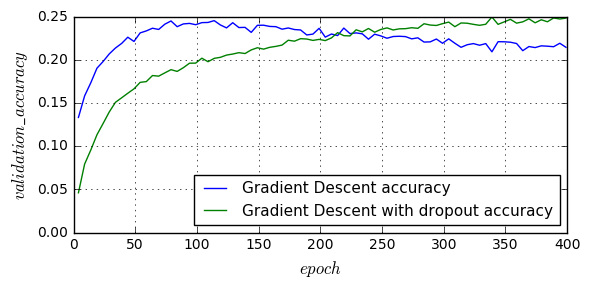

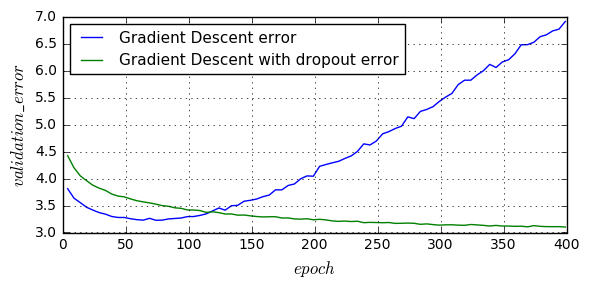

In [71]:
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(4, 400, 5), grad_descent_valid_acc, label='Gradient Descent accuracy')
ax.plot(np.arange(4, 400, 5), dropout_validation_accs, label='Gradient Descent with dropout accuracy')
ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_accuracy$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('dropout_acc_comparison.pdf') 


# -- PRINT MIN ERROR CHANGE OVER ETA
fig_size = (6, 3) 
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(4, 400, 5), grad_descent_valid_error, label='Gradient Descent error')
ax.plot(np.arange(4, 400, 5), dropout_validation_errors, label='Gradient Descent with dropout error')
ax.set_xlabel('$epoch$', fontsize=12)
ax.set_ylabel('$validation\_error$', fontsize=12)
ax.grid('on')
ax.legend(loc='best', fontsize=11) 
fig.tight_layout() 
fig.savefig('dropout_err_comparison.pdf') 

print("------  dropout  --------")
print("minimum validation error is {}".format(min(dropout_validation_errors)))
print("maximum validation accuracy is {}".format(max(dropout_validation_accs)))
print("time is {}".format(drop_out_time))

                 err(valid)=3.259210 acc(valid)=0.222200
                 err(valid)=3.240431 acc(valid)=0.224200
                 err(valid)=3.241652 acc(valid)=0.225500
                 err(valid)=3.227995 acc(valid)=0.224400
                 err(valid)=3.211874 acc(valid)=0.227400
                 err(valid)=3.216462 acc(valid)=0.228400
                 err(valid)=3.213471 acc(valid)=0.231400
                 err(valid)=3.185515 acc(valid)=0.235600
                 err(valid)=3.201435 acc(valid)=0.229600
                 err(valid)=3.183978 acc(valid)=0.237000


                 err(valid)=3.196633 acc(valid)=0.232500
                 err(valid)=3.202266 acc(valid)=0.233400
                 err(valid)=3.164468 acc(valid)=0.237700
                 err(valid)=3.202573 acc(valid)=0.225900
                 err(valid)=3.150112 acc(valid)=0.235700
                 err(valid)=3.165543 acc(valid)=0.230900
                 err(valid)=3.134730 acc(valid)=0.241300
                 err(valid)=3.164301 acc(valid)=0.236100
                 err(valid)=3.141961 acc(valid)=0.241900
                 err(valid)=3.133629 acc(valid)=0.242800


                 err(valid)=3.134518 acc(valid)=0.240200
                 err(valid)=3.129267 acc(valid)=0.243400
                 err(valid)=3.129569 acc(valid)=0.245100
                 err(valid)=3.156259 acc(valid)=0.235700
                 err(valid)=3.130662 acc(valid)=0.245000
                 err(valid)=3.110819 acc(valid)=0.241800
                 err(valid)=3.119901 acc(valid)=0.242600
                 err(valid)=3.110158 acc(valid)=0.249100
                 err(valid)=3.123203 acc(valid)=0.244600
                 err(valid)=3.104606 acc(valid)=0.249000


                 err(valid)=3.112355 acc(valid)=0.252700
                 err(valid)=3.113196 acc(valid)=0.245300
                 err(valid)=3.109047 acc(valid)=0.247000
                 err(valid)=3.113370 acc(valid)=0.248400
                 err(valid)=3.114273 acc(valid)=0.249200
                 err(valid)=3.116372 acc(valid)=0.246700
                 err(valid)=3.103298 acc(valid)=0.247700
                 err(valid)=3.101743 acc(valid)=0.250700
                 err(valid)=3.110666 acc(valid)=0.249000
                 err(valid)=3.099406 acc(valid)=0.250700


                 err(valid)=3.088221 acc(valid)=0.252300
                 err(valid)=3.097280 acc(valid)=0.252200
                 err(valid)=3.096065 acc(valid)=0.252700
                 err(valid)=3.090894 acc(valid)=0.248900
                 err(valid)=3.111924 acc(valid)=0.248300
                 err(valid)=3.126903 acc(valid)=0.246100
                 err(valid)=3.100272 acc(valid)=0.248400
                 err(valid)=3.089612 acc(valid)=0.250000
                 err(valid)=3.102499 acc(valid)=0.249600
                 err(valid)=3.100324 acc(valid)=0.251100


                 err(valid)=3.105748 acc(valid)=0.249700
                 err(valid)=3.105164 acc(valid)=0.250700
                 err(valid)=3.098855 acc(valid)=0.251300
                 err(valid)=3.102018 acc(valid)=0.252800
                 err(valid)=3.100671 acc(valid)=0.249500
                 err(valid)=3.105811 acc(valid)=0.246300
                 err(valid)=3.102174 acc(valid)=0.246000
                 err(valid)=3.089053 acc(valid)=0.253000
                 err(valid)=3.096703 acc(valid)=0.250700
                 err(valid)=3.129807 acc(valid)=0.247700


In [ ]:
# --------------- test multitask ----------------
print('---------- Gradient Descent-----------')
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate=eta_simple_grad_descent).minimize(error)
init = tf.global_variables_initializer()use_coarse_targets
sess = tf.Session()
sess.run(init)
epochs = []
grad_descent_valid_error = []
grad_descent_valid_acc = []

t = t.time()
for e in range(400):
    # training step
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})

    if ((e+1)%5==0):
        # validate
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        
        epochs += [e]
        grad_descent_valid_error += [valid_error]
        grad_descent_valid_acc += [valid_accuracy]
        
        print('                 err(valid)={0:.6f} acc(valid)={1:.6f}'
               .format(valid_error, valid_accuracy))
gradient_descent_time = t.time()-t